In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

In [ ]:
!pip install numpy
!pip install pandas
!pip install cvlib
!pip install opencv-python
!pip install imutils
!pip install tensorflow
!pip install joblib
!pip install dlib-19.24.99-cp312-cp312-win_amd64.whl
!pip install xgboost
!pip install catboost

C:\Users\veere\AppData\Local\Temp\ipykernel_21496\442670534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['BMI_Category'] = pd.cut(women['BMI'], bins=bins, labels=labels)
C:\Users\veere\AppData\Local\Temp\ipykernel_21496\442670534.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_women = women.groupby('BMI_Category', group_keys=False).apply(
C:\Users\veere\AppData\Local\Temp\ipykernel_21496\442670534.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version 

BMI_Category
Obesity        1602
Overweight     1115
Normal          896
Underweight      34
Name: count, dtype: int64
              name date_of_birth    weight     sex  height  Age        BMI  \
45592   NATASHA J.    07/02/1987   47.1744  Female  1.6256   37  17.851676   
49739        TERRI    04/16/1962   47.6280  Female  1.7018   62  16.445433   
54373    CARRIE R.    06/29/1986   48.5352  Female  1.6256   38  18.366629   
53409       LATELE    09/16/1992   50.8032  Female  1.6764   32  18.077392   
44474     EMILY L.    03/04/1988   45.8136  Female  1.6002   36  17.891464   
...            ...           ...       ...     ...     ...  ...        ...   
45797     TEMPESTT    04/21/1987  126.5544  Female  1.5748   37  51.030102   
53541     DEBRA F.    01/14/1951  116.1216  Female  1.6002   73  45.348662   
45147      TIFFANY    04/15/1974   98.8848  Female  1.7018   50  34.143851   
56882   ALEXIUS C.    01/30/1993  104.3280  Female  1.7272   31  34.971610   
45790     TRACY M.    0

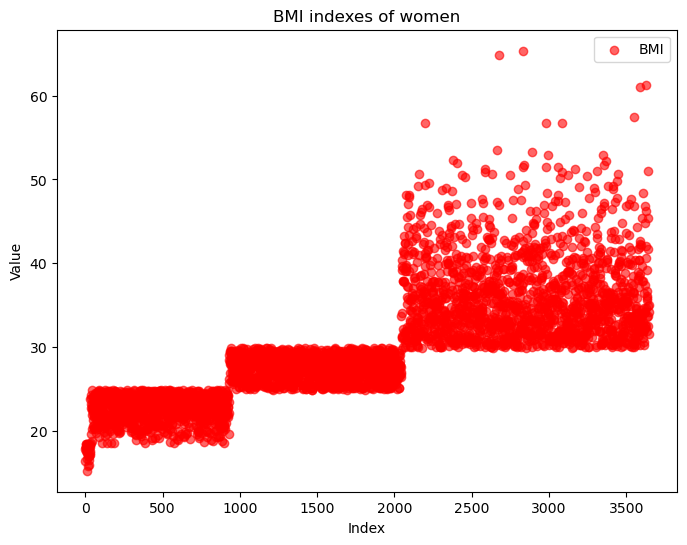

In [3]:
data = pd.read_csv('output.csv')
data
women = data[data['sex']=='Female']
# Create BMI bins (you can adjust the bin ranges based on your data)
bins = [0, 18.5, 24.9, 29.9, np.inf]  # Standard BMI categories
labels = ['Underweight', 'Normal', 'Overweight','Obesity']
women['BMI_Category'] = pd.cut(women['BMI'], bins=bins, labels=labels)

# Stratified sampling: Sample 4000 men proportional to the BMI categories
sampled_women = women.groupby('BMI_Category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), int(4000 * len(x) / len(women))), random_state=42)
)

# Display the sampled dataset
print(sampled_women['BMI_Category'].value_counts())
print(sampled_women)

women = sampled_women['BMI']

plt.figure(figsize=(8, 6))
plt.scatter(range(len(women)), women, label="BMI", color="red", alpha=0.6)

plt.title('BMI indexes of women')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

C:\Users\veere\AppData\Local\Temp\ipykernel_21496\1250653610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['BMI_Category'] = pd.cut(men['BMI'], bins=bins, labels=labels)
C:\Users\veere\AppData\Local\Temp\ipykernel_21496\1250653610.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_men = men.groupby('BMI_Category', group_keys=False).apply(
C:\Users\veere\AppData\Local\Temp\ipykernel_21496\1250653610.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pand

BMI_Category
Overweight     1675
Normal         1180
Obesity        1123
Underweight      20
Name: count, dtype: int64
              name date_of_birth    weight   sex  height  Age        BMI  \
11218       WILLIE    05/18/1976   53.5248  Male  1.7018   48  18.481534   
34522   WILLIAM H.    12/11/1979   63.5040  Male  1.8542   44  18.470895   
55041     TERRONDE    04/21/1998   54.4320  Male  1.8034   26  16.736713   
10626      KENNETH    08/24/1978   63.5040  Male  1.8796   46  17.975054   
41210   SHANNON T.    01/08/1985   52.1640  Male  1.7526   39  16.982643   
...            ...           ...       ...   ...     ...  ...        ...   
17213         ALEX    06/04/1992  100.6992  Male  1.7526   32  32.783884   
12897      PAUL M.    08/05/1982   88.4520  Male  1.7018   42  30.541518   
14045   RICHARD L.    12/19/1965   92.5344  Male  1.7526   58  30.125731   
35613    RONNIE D.    05/02/1985  102.0600  Male  1.7526   39  33.226910   
23868        HOANG    04/19/1993   81.6480  M

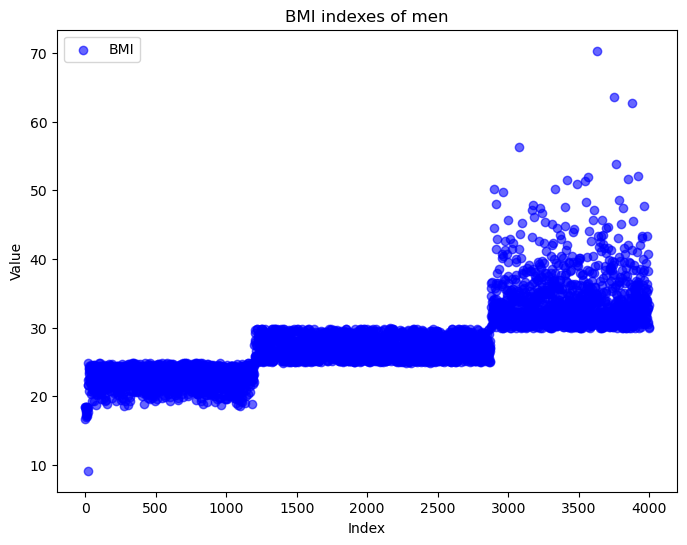

In [4]:
men = data[data['sex']=='Male']

# Create BMI bins (you can adjust the bin ranges based on your data)
bins = [0, 18.5, 24.9, 29.9, np.inf]  # Standard BMI categories
labels = ['Underweight', 'Normal', 'Overweight','Obesity']
men['BMI_Category'] = pd.cut(men['BMI'], bins=bins, labels=labels)

# Stratified sampling: Sample 4000 men proportional to the BMI categories
sampled_men = men.groupby('BMI_Category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), int(4000 * len(x) / len(men))), random_state=42)
)

# Display the sampled dataset
print(sampled_men['BMI_Category'].value_counts())
print(sampled_men)

men = sampled_men['BMI']

plt.figure(figsize=(8, 6))
plt.scatter(range(len(men)), men, label="BMI", color="blue", alpha=0.6)

plt.title('BMI indexes of men')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [5]:
sampled_women['sex'] = 1
sampled_men['sex'] = 0

total_data = pd.concat([sampled_men, sampled_women], ignore_index=True)
# null_values = total_data.isnull().sum()

total_datax = total_data[['front_CJWR', 'front_WHR', 'front_PAR', 'front_ES','front_FW/FH', 'front_MEH', 'sex']]
total_datax
total_datay = total_data[['BMI']]
total_datay

,BMI
0,18.481534
1,18.470895
2,16.736713
3,17.975054
4,16.982643
...,...
7640,51.030102
7641,45.348662
7642,34.143851
7643,34.971610


In [7]:
#normalising the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(total_datax)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(total_datax, total_datay, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(total_datax, total_datay, test_size=0.2, random_state=42)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Linear Regression:")
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)
tolerance = 5  # Define a tolerance value

# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")



# Save the model
joblib.dump(lr, './models/linear_reg2.pkl')

Linear Regression:
MSE: 29.351954186861988
R2 Score: 0.1949192503425311
Mean Absolute Error: 4.181342252436975
Pearson Correlation Coefficient: 0.44325452062035975
Prediction Accuracy within ±5 units: 68.14911706998038


['./models/linear_reg2.pkl']

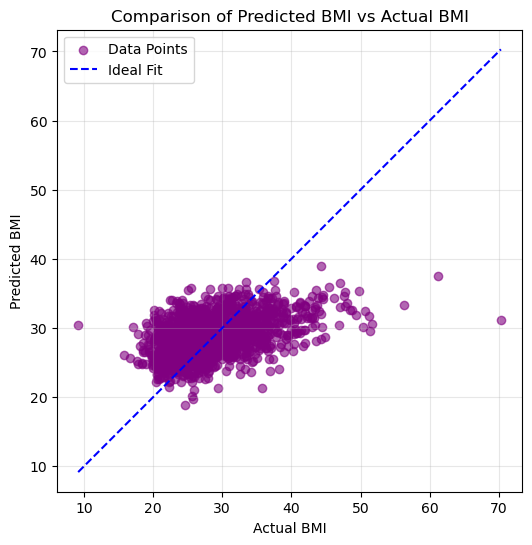

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="purple", alpha=0.6, label="Data Points")

# Add the ideal fit line (y = x) with a dotted style
min_val = min(min(y_test), min(y_pred))  # Determine the minimum value in both datasets
max_val = max(max(y_test), max(y_pred))  # Determine the maximum value in both datasets
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="blue", label="Ideal Fit")

plt.title('Comparison of Predicted BMI vs Actual BMI')
plt.ylabel('Predicted BMI')
plt.xlabel('Actual BMI')
plt.axis("equal")  # Ensures equal scaling on both axes
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [63]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(xgb, './models/XGB_regg2.pkl')


MSE: 33.75409886816637
R2 Score: 0.07417492382980051
Mean Absolute Error: 4.494469999672175
Pearson Correlation Coefficient: 0.3651345387040018
Prediction Accuracy within ±5 units: 64.35578809679528


['./models/XGB_regg2.pkl']

In [45]:
# Initialize CatBoost Regressor
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='RMSE', 
                           verbose=100)

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test = y_test.squeeze()  # Converts a DataFrame with one column into a Series
y_pred = y_pred.squeeze()
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value
# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test - y_pred) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(model, './models/cat_reg2.pkl')

0:	learn: 6.0479162	total: 6.07ms	remaining: 6.07s
100:	learn: 5.1129656	total: 394ms	remaining: 3.51s
200:	learn: 4.8320345	total: 789ms	remaining: 3.13s
300:	learn: 4.6001427	total: 1.16s	remaining: 2.7s
400:	learn: 4.3878352	total: 1.56s	remaining: 2.33s
500:	learn: 4.2000611	total: 1.96s	remaining: 1.95s
600:	learn: 4.0296883	total: 2.34s	remaining: 1.55s
700:	learn: 3.8652921	total: 2.72s	remaining: 1.16s
800:	learn: 3.7179876	total: 3.1s	remaining: 770ms
900:	learn: 3.5700814	total: 3.46s	remaining: 381ms
999:	learn: 3.4390749	total: 3.84s	remaining: 0us
MSE: 32.14968669374613
R2 Score: 0.11818158001080448
Mean Absolute Error: 4.337097396877468
Pearson Correlation Coefficient: 0.38861334856395774
Prediction Accuracy within ±5 units: 66.18705035971223


['./models/cat_reg2.pkl']

In [51]:
lr = LinearRegression()
lr.fit(X_train2, y_train2)

y_pred2 = lr.predict(X_test2)
print("Linear Regression:")
y_test2 = y_test2.squeeze()  # Converts a DataFrame with one column into a Series
y_pred2 = y_pred2.squeeze()
print("MSE:", mean_squared_error(y_test2, y_pred2))
print("R2 Score:", r2_score(y_test2, y_pred2))
print("Mean Absolute Error:", mean_absolute_error(y_test2, y_pred2))
pearson_corr, _ = pearsonr(y_test2, y_pred2)
print("Pearson Correlation Coefficient:", pearson_corr)
tolerance = 5  # Define a tolerance value

# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test2 - y_pred2) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

# Save the model
joblib.dump(lr, './models/linear_reg2a.pkl')

Linear Regression:
MSE: 29.351954186861988
R2 Score: 0.1949192503425311
Mean Absolute Error: 4.181342252436975
Pearson Correlation Coefficient: 0.44325452062035975
Prediction Accuracy within ±5 units: 68.14911706998038


['./models/linear_reg2a.pkl']

In [53]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train2, y_train2)

y_pred2 = xgb.predict(X_test2)
y_test2 = y_test2.squeeze()  # Converts a DataFrame with one column into a Series
y_pred2 = y_pred2.squeeze()
print("MSE:", mean_squared_error(y_test2, y_pred2))
print("R2 Score:", r2_score(y_test2, y_pred2))
print("Mean Absolute Error:", mean_absolute_error(y_test2, y_pred2))
pearson_corr, _ = pearsonr(y_test2, y_pred2)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value


# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test2 - y_pred2) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(xgb, './models/XGB_regg2a.pkl')


MSE: 33.75409886816637
R2 Score: 0.07417492382980051
Mean Absolute Error: 4.494469999672175
Pearson Correlation Coefficient: 0.3651345387040018
Prediction Accuracy within ±5 units: 64.35578809679528


['./models/XGB_regg2a.pkl']

In [57]:
# Initialize CatBoost Regressor
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='RMSE', 
                           verbose=100)

# Fit the model
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_test2)

y_test2 = y_test2.squeeze()  # Converts a DataFrame with one column into a Series
y_pred2 = y_pred2.squeeze()
print("MSE:", mean_squared_error(y_test2, y_pred2))
print("R2 Score:", r2_score(y_test2, y_pred2))
print("Mean Absolute Error:", mean_absolute_error(y_test2, y_pred2))
pearson_corr, _ = pearsonr(y_test2, y_pred2)
print("Pearson Correlation Coefficient:", pearson_corr)

tolerance = 5  # Define a tolerance value
# Calculate percentage of predictions within the tolerance
accuracy = (np.abs(y_test2 - y_pred2) <= tolerance).mean() * 100
print(f"Prediction Accuracy within ±{tolerance} units: {accuracy}")

joblib.dump(model, './models/cat_reg2a.pkl')

0:	learn: 6.0479162	total: 5.64ms	remaining: 5.64s
100:	learn: 5.1129656	total: 403ms	remaining: 3.59s
200:	learn: 4.8320345	total: 778ms	remaining: 3.09s
300:	learn: 4.6001427	total: 1.17s	remaining: 2.72s
400:	learn: 4.3878352	total: 1.55s	remaining: 2.32s
500:	learn: 4.2000611	total: 1.91s	remaining: 1.9s
600:	learn: 4.0296883	total: 2.3s	remaining: 1.52s
700:	learn: 3.8652921	total: 2.67s	remaining: 1.14s
800:	learn: 3.7179876	total: 3.04s	remaining: 756ms
900:	learn: 3.5700814	total: 3.42s	remaining: 376ms
999:	learn: 3.4390749	total: 3.8s	remaining: 0us
MSE: 32.14968669374613
R2 Score: 0.11818158001080448
Mean Absolute Error: 4.337097396877468
Pearson Correlation Coefficient: 0.38861334856395774
Prediction Accuracy within ±5 units: 66.18705035971223


['./models/cat_reg2a.pkl']

[27.23506947 31.89814652 28.28939602 ... 29.11119731 33.99775574
 29.62866039]
2598    27.396305
6317    34.365783
2462    27.762929
4508    19.802766
4743    21.216817
          ...    
4848    24.800050
5994    29.010302
1192    23.056296
4220    22.798143
5944    28.520057
Name: BMI, Length: 1529, dtype: float64


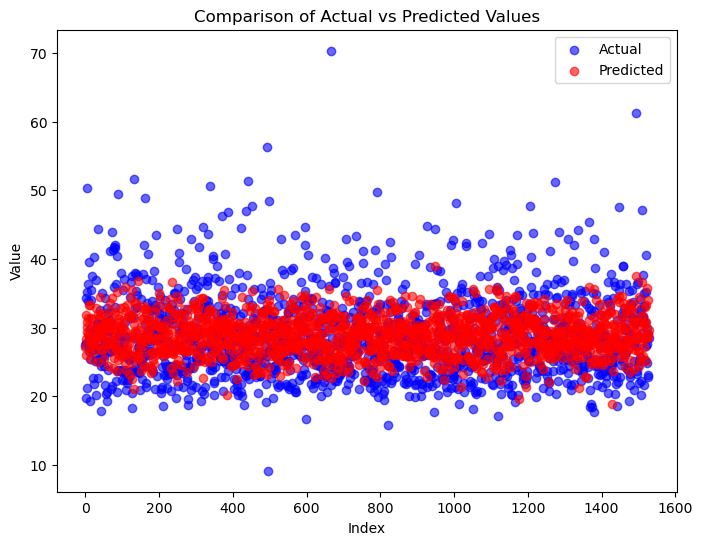

In [17]:
# Example: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", color="red", alpha=0.6)

print(y_pred)
print(y_test)

plt.title('Comparison of Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
